In [1]:
cd ../../

/workspaces/research/seeg localization/SPORF


In [2]:
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne_bids.read import read_raw_bids
from mne_bids.write import make_bids_basename
from rerf.rerfClassifier import rerfClassifier
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from tqdm import tqdm

from mtsmorf.io.read import read_dataset, read_label, read_trial, get_trial_info
from mtsmorf.io.utils import NumpyEncoder
from mtsmorf.war_exp.cv import nested_cv_fit, cv_fit, bootstrap_fit

%load_ext autoreload
%autoreload 2

# Load data

In [3]:
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")
bids_root = Path("/workspaces/research/mnt/data/efri")

# subject identifiers
subject = "efri02"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_fname = make_bids_basename(subject=subject, session=session, task=task,
                                acquisition=acquisition, run=run, suffix=f"{kind}.vhdr")

In [4]:
picks = []

# fetch labels
labels, trial_ids = read_label(bids_fname, bids_root, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_fname, bids_root)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

Out of 135 trials, there were 132 successful trials in sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 135 trials, there were 132 successful trials in sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.


In [9]:
# read dataset as an epoch
tmin, tmax = (-0.5, 1.0)

# get EEG data
epochs = read_dataset(bids_fname, bids_root, tmin=tmin, tmax=tmax, picks=picks, event_key="Left Target")
epochs = epochs.drop(unsuccessful_trial_inds)
epochs.load_data()
epochs_data = epochs.get_data()

# get shape of data
ntrials, nchs, nsteps = epochs_data.shape

# check there are equal number of trials and labels
assert(ntrials == labels.shape[0]), "Unequal number of trials and labels"

Extracting parameters from /workspaces/research/mnt/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /workspaces/research/mnt/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /workspaces/research/mnt/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Out of 135 trials, there were 132 successful trials in sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Leave Target', 'Left Target', 'Reserved (End Trial)', 'Reserved (Start Trial)', 'Reward', 'Show Center', 'Speed Fail', 'Speed Feedback', 'Speed Instruction']
Not setting metadata
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Dropped 27 epochs: 0, 8, 9, 17, 21, 24

In [10]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Band-pass filter 1 Hz to sfreq/2
data = mne.filter.filter_data(epochs_data, sfreq=2000, l_freq=1, h_freq=999)
X = data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

Setting up band-pass filter from 1 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 999.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 999.50 Hz)
- Filter length: 6601 samples (3.300 sec)



In [11]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [12]:
down = epochs_data[labels == 0]
right = epochs_data[labels == 1]
up = epochs_data[labels == 2]
left = epochs_data[labels == 3]

In [13]:
####### PLOT LFPs #######

# t = epochs.times
# fig, axs = plt.subplots(nrows=int(np.ceil(nchs / 4)), ncols=4, figsize=(15, 45))
# axs = axs.flatten()

# for i, ch in enumerate(epochs.ch_names):
#     ax = axs[i]
#     avg_signal0, lower_bound0, upper_bound0 = mean_confidence_interval(down[:, i])
#     avg_signal1, lower_bound1, upper_bound1 = mean_confidence_interval(right[:, i])
#     avg_signal2, lower_bound2, upper_bound2 = mean_confidence_interval(up[:, i])
#     avg_signal3, lower_bound3, upper_bound3 = mean_confidence_interval(left[:, i])

#     sns.lineplot(t, avg_signal0, ax=ax)
#     ax.fill_between(t, lower_bound0, upper_bound0, alpha=0.3, label='1: Down')
    
#     sns.lineplot(t, avg_signal1, ax=ax)
#     ax.fill_between(t, lower_bound1, upper_bound1, alpha=0.3, label='2: Right')

#     sns.lineplot(t, avg_signal2, ax=ax)
#     ax.fill_between(t, lower_bound2, upper_bound2, alpha=0.3, label='3: Up')

#     sns.lineplot(t, avg_signal3, ax=ax)
#     ax.fill_between(t, lower_bound3, upper_bound3, alpha=0.3, label='4: Left')

#     ax.legend()
#     ax.set(title=f'Average LFP for {ch}', xlabel='Time (s)', ylabel='LFP (mV)')

# fig.tight_layout();

## Multi-label train-test split

In [14]:
test_size = 0.2
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=test_size, random_state=rng, stratify=y)

In [15]:
print(Counter(ytest))

Counter({0.0: 6, 2.0: 5, 1.0: 5, 3.0: 5})


In [13]:
mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

mtsmorf.fit(Xtrain, ytrain)

preds = mtsmorf.predict(Xtest)

print(Counter(preds))
print(f"Accuracy: {accuracy_score(ytest, preds)}")

Counter({0: 6, 3: 4, 2: 4, 1: 2})
Accuracy: 0.625


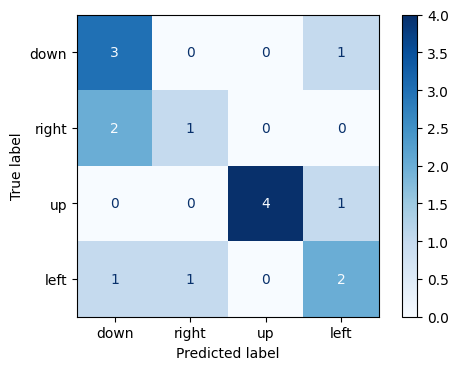

In [14]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(dpi=100)
plot_confusion_matrix(mtsmorf, Xtest, ytest, cmap='Blues', ax=ax)
ax.set(xticklabels=['down', 'right', 'up', 'left'], yticklabels=['down', 'right', 'up', 'left']);

In [15]:
srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

srerf.fit(Xtrain, ytrain)

preds = srerf.predict(Xtest)

print(Counter(preds))
print(f"Accuracy: {accuracy_score(ytest, preds)}")

Counter({0: 6, 2: 4, 3: 3, 1: 3})
Accuracy: 0.5


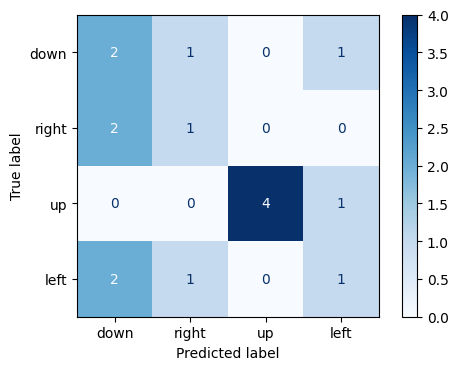

In [16]:
fig, ax = plt.subplots(dpi=100)
plot_confusion_matrix(srerf, Xtest, ytest, cmap='Blues', ax=ax)
ax.set(xticklabels=['down', 'right', 'up', 'left'], yticklabels=['down', 'right', 'up', 'left']);

In [17]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent', random_state=rng)

dummy.fit(Xtrain, ytrain)

preds = dummy.predict(Xtest)

print(Counter(preds))
print(f"Accuracy: {accuracy_score(ytest, preds)}")


Counter({0.0: 16})
Accuracy: 0.25


## Multi-label KFold

In [18]:
included_trials = np.isin(labels, [0, 1, 2, 3])
X = epochs_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

In [19]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

# mcnemar test
mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

cv = KFold(n_splits=5, shuffle=False, random_state=rng)
scores = cv_fit(mtsmorf, X, y, cv=cv, metrics=metrics, n_jobs=None, return_train_score=True)
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

In [ ]:
df_cm = pd.DataFrame(scores['test_confusion_matrix'][0], index=['down', 'right', 'up', 'left'],
                  columns=['down', 'right', 'up', 'left'])

fig, ax = plt.subplots(dpi=100)

sns.heatmap(df_cm, annot=True, cmap='Blues', ax=ax)
ax.set(xlabel='Predicted label', ylabel='True label', title=f"{mtsmorf.get_params()['projection_matrix']}")

fig.tight_layout();

## Multi-label Stratified KFold

In [21]:
mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

test_set_size = 15
cv = StratifiedKFold(n_splits=5)
stratified_kf_scores = cv_fit(mtsmorf, X[:-test_set_size], y[:-test_set_size], metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

In [22]:
# StratifiedKFold
for j, estimator in enumerate(stratified_kf_scores['estimator']):
    y_true = y[-test_set_size:]
    y_pred = estimator.predict(X[-test_set_size:])

    print(f"{j}: {accuracy_score(y_true, y_pred)}")

0: 0.4
1: 0.5333333333333333
2: 0.4
3: 0.6666666666666666
4: 0.6666666666666666


## Feature Importance
- Remove B7
- Permutation importance (`bug`)

In [23]:
picks = epochs.ch_names
picks.remove("B7")

In [24]:
# fetch labels
labels, trial_ids = read_label(bids_fname, bids_root, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_fname, bids_root)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

Out of 98 trials, there were 96 successful trials in sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 98 trials, there were 96 successful trials in sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.


In [25]:
# read dataset as an epoch
tmin, tmax = (-0.5, 1.0)

# get EEG data
epochs = read_dataset(bids_fname, bids_root, tmin=tmin, tmax=tmax, picks=picks, event_key="Left Target")
epochs = epochs.drop(unsuccessful_trial_inds)
epochs.load_data()
epochs_data = epochs.get_data()

# get shape of data
ntrials, nchs, nsteps = epochs_data.shape

# check there are equal number of trials and labels
assert(ntrials == labels.shape[0]), "Unequal number of trials and labels"

Extracting parameters from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Out of 98 trials, there were 96 successful trials in sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Left Target', 'Reserved (End Trial)', 'Reserved (Start Trial)', 'Reward', 'Show Center', 'Speed Fail', 'Speed Feedback', 'Speed Instruction']
Not setting metadata
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Dropped 20 epochs: 3, 4, 9, 12, 13, 33, 38, 40, 41, 48, 5

In [26]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Band-pass filter 1 Hz to sfreq/2
data = mne.filter.filter_data(epochs_data, sfreq=2000, l_freq=1, h_freq=999)
X = data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

Setting up band-pass filter from 1 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 999.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 999.50 Hz)
- Filter length: 6601 samples (3.300 sec)



In [27]:
test_size = 0.2
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=test_size, random_state=rng, stratify=y)

In [28]:
mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

mtsmorf.fit(Xtrain, ytrain)

preds = np.array(mtsmorf.predict(Xtest))

print(Counter(preds))
print(f"Accuracy: {accuracy_score(ytest, preds)}")

Counter({2: 6, 0: 6, 1: 2, 3: 2})
Accuracy: 0.3125


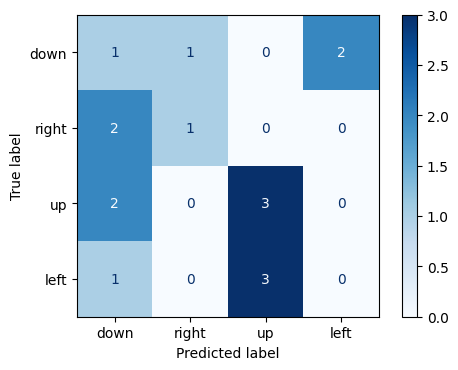

In [29]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(dpi=100)
plot_confusion_matrix(mtsmorf, Xtest, ytest, cmap='Blues', ax=ax)

ax.set(xticklabels=['down', 'right', 'up', 'left'], yticklabels=['down', 'right', 'up', 'left']);

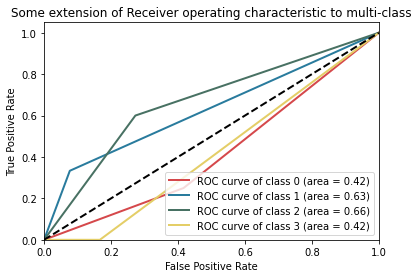

In [30]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
lw = 2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(ytest, classes=[0,1,2,3])[:, i], label_binarize(preds, classes=[0,1,2,3])[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['#D5484B', '#297B9D', '#487163', '#E4CE67', '#87425D'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One vs. Rest ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [23]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

test_size = 0.3
n_repeats = 1

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=test_size, random_state=rng, stratify=y)

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
).fit(Xtrain, ytrain)

In [21]:
# Check versioning on numpy, scipy, sklearn, etc packages
# Score with roc_auc_ovr

result = permutation_importance(mtsmorf, Xtest, ytest, scoring='accuracy', n_repeats=n_repeats, n_jobs=1, random_state=1)

# for i in result.importances_mean.argsort()[::-1]:
#     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
#         # print(f"{diabetes.feature_names[i]:<8}"
#         print(f"{result.importances_mean[i]:.3f}"
#               f" +/- {result.importances_std[i]:.3f}")

feat_importance_means = result['importances_mean'].reshape(nchs, nsteps)
feat_importance_stds = result['importances_std'].reshape(nchs, nsteps)
feat_importances = result['importances'].reshape(nchs, nsteps, n_repeats)

df_cm = pd.DataFrame(feat_importance_means)

sns.heatmap(df_feat_importance, annot=True, cmap='Blues', ax=ax)

MemoryError: std::bad_alloc